## Generate Static Graphs

These are the input parameters for the notebook. They will be automatically changed when the scripts to generate monthly statistics are run. You can modify them manually to generate multiple plots locally as well.

Pass in `None` to remove the filters and plot all data. This is not recommended for production settings, but might be useful for reports based on data snapshots.

In [1]:
#path configuration
to_data_folder = "../Data" #data folder, where composite data was written from the TSDC_data file

In [2]:
year = None
month = None
program = "default"
study_type = "program"
mode_of_interest = "E-bike"
include_test_users = False

In [3]:
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns

from plots import *
import scaffolding

import emission.core.get_database as edb
import emission.storage.timeseries.abstract_timeseries as esta

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

URL not formatted, defaulting to "Stage_database"
Connecting to database URL db


In [4]:
# Do not run this notebook at all unless it is for a program; nbclient will run up through this cell
if study_type != "program":
    ipython = get_ipython()
    ipython._showtraceback = scaffolding.no_traceback_handler
    raise Exception("The plots in this notebook are only relevant to programs")

In [5]:
df_pur = pd.read_csv(r'../../auxiliary_files/purpose_labels.csv')
df_re = pd.read_csv(r'../../auxiliary_files/mode_labels.csv')
df_ei = pd.read_csv(r'../../auxiliary_files/energy_intensity.csv')

#dictionaries:
dic_pur = dict(zip(df_pur['purpose_confirm'],df_pur['bin_purpose'])) # bin purpose
dic_re  = dict(zip(df_re['replaced_mode'],df_re['mode_clean'])) # bin modes
dic_fuel = dict(zip(df_ei['mode'],df_ei['fuel']))

In [6]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r df_ei
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_re = defaultdict(lambda: 'Other',dic_re)
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_fuel = defaultdict(lambda: 'Other',dic_fuel)

In [7]:
def no_traceback_handler(exception_type, exception, traceback):
    print("%s: %s" % (exception_type.__name__, exception), file=sys.stderr)

def get_time_query(year, month):
    if year is None and month is None:
        return None

    if month is None:
        assert year is not None
        query_ld = ecwl.LocalDate({"year": year})
    else:
        assert year is not None and month is not None
        query_ld = ecwl.LocalDate({"year": year, "month": month})
    tq = esttc.TimeComponentQuery("data.start_local_dt", query_ld, query_ld)
    return tq

def get_participant_uuids(program, load_test_users):
    """
        Get the list of non-test users in the current program.
        Note that the "program" parameter is currently a NOP and should be removed in
        conjunction with modifying the notebooks.
    """
    all_users = pd.json_normalize(list(edb.get_uuid_db().find()))
    # CASE 1 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
    if len(all_users) == 0:
        return []
    if load_test_users:
        participant_list = all_users
    else:
        participant_list = all_users[np.logical_not(all_users.user_email.str.contains("_test_"))]
    participant_uuid_str = participant_list.uuid
    disp.display(participant_list.user_email)
    return participant_uuid_str

def load_all_confirmed_trips(tq):
    agg = esta.TimeSeries.get_aggregate_time_series()
    all_ct = agg.get_data_df("analysis/confirmed_trip", tq)
    print("Loaded all confirmed trips of length %s" % len(all_ct))
    disp.display(all_ct.head())
    return all_ct

def load_all_participant_trips(program, tq, load_test_users):
    participant_list = get_participant_uuids(program, load_test_users)
    all_ct = load_all_confirmed_trips(tq)
    # CASE 1 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
    if len(all_ct) == 0:
        return all_ct
    participant_ct_df = all_ct[all_ct.user_id.isin(participant_list)]
    print("After filtering, found %s participant trips " % len(participant_ct_df))
    disp.display(participant_ct_df.head())
    return participant_ct_df

def filter_labeled_trips(mixed_trip_df):
    # CASE 1 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
    if len(mixed_trip_df) == 0:
        return mixed_trip_df
    labeled_ct = mixed_trip_df[mixed_trip_df.user_input != {}]
    print("After filtering, found %s labeled trips" % len(labeled_ct))
    disp.display(labeled_ct.head())
    return labeled_ct

def expand_userinputs(labeled_ct):
    '''
    param: labeled_ct: a dataframe of confirmed trips, some of which have labels
    params: labels_per_trip: the number of labels for each trip.
        Currently, this is 2 for studies and 3 for programs, and should be 
        passed in by the notebook based on the input config.
        If used with a trip-level survey, it could be even larger.
    '''
    # CASE 1 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
    if len(labeled_ct) == 0:
        return labeled_ct
    label_only = pd.DataFrame(labeled_ct.user_input.to_list(), index=labeled_ct.index)
    disp.display(label_only.head())
    labels_per_trip = len(label_only.columns)
    print("Found %s columns of length %d" % (label_only.columns, labels_per_trip))
    expanded_ct = pd.concat([labeled_ct, label_only], axis=1)
    assert len(expanded_ct) == len(labeled_ct), \
        ("Mismatch after expanding labels, expanded_ct.rows = %s != labeled_ct.rows %s" %
            (len(expanded_ct), len(labeled_ct)))
    print("After expanding, columns went from %s -> %s" %
        (len(labeled_ct.columns), len(expanded_ct.columns)))
    assert len(expanded_ct.columns) == len(labeled_ct.columns) + labels_per_trip, \
        ("Mismatch after expanding labels, expanded_ct.columns = %s != labeled_ct.columns %s" %
            (len(expanded_ct.columns), len(labeled_ct.columns)))
    disp.display(expanded_ct.head())
    return expanded_ct

# CASE 2 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
unique_users = lambda df: len(df.user_id.unique()) if "user_id" in df.columns else 0
trip_label_count = lambda s, df: len(df[s].dropna()) if s in df.columns else 0

def load_viz_notebook_data(year, month, program, study_type, dic_re, dic_pur=None, include_test_users=False):
    """ Inputs:
    year/month/program/study_type = parameters from the visualization notebook
    dic_* = label mappings; if dic_pur is included it will be used to recode trip purpose
    
    Pipeline to load and process the data before use in visualization notebooks.
    """
    # Access database
    expanded_ct=pd.read_csv(to_data_folder + "/filtered_merged_trips.csv")
    tq = get_time_query(year, month)
    participant_ct_df = load_all_participant_trips(program, tq, include_test_users)
    labeled_ct = filter_labeled_trips(participant_ct_df)
    expanded_ct = expand_userinputs(labeled_ct)
    expanded_ct = data_quality_check(expanded_ct)
    

    # Change meters to miles
    # CASE 2 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
    if "distance" in expanded_ct.columns:
        unit_conversions(expanded_ct)

    # Mapping new mode labels with dictionaries
    # CASE 2 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
    if "mode_confirm" in expanded_ct.columns:
        expanded_ct['Mode_confirm']= expanded_ct['mode_confirm'].map(dic_re)
    if study_type == 'program':
        # CASE 2 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
        if 'replaced_mode' in expanded_ct.columns:
            expanded_ct['Replaced_mode']= expanded_ct['replaced_mode'].map(dic_re)
        else:
            print("This is a program, but no replaced modes found. Likely cold start case. Ignoring replaced mode mapping")
    else:
            print("This is a study, not expecting any replaced modes.")

    # Trip purpose mapping
    # CASE 2 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
    if dic_pur is not None and "purpose_confirm" in expanded_ct.columns:
        expanded_ct['Trip_purpose']= expanded_ct['purpose_confirm'].map(dic_pur)

    # Document data quality
    file_suffix = get_file_suffix(year, month, program)
    quality_text = get_quality_text(participant_ct_df, expanded_ct, None, include_test_users)

    debug_df = pd.DataFrame.from_dict({
            "year": year,
            "month": month,
            "Registered_participants": len(get_participant_uuids(program, include_test_users)),
            "Participants_with_at_least_one_trip": unique_users(participant_ct_df),
            "Participant_with_at_least_one_labeled_trip": unique_users(labeled_ct),
            "Trips_with_at_least_one_label": len(labeled_ct),
            "Trips_with_mode_confirm_label": trip_label_count("Mode_confirm", expanded_ct),
            "Trips_with_trip_purpose_label": trip_label_count("Trip_purpose", expanded_ct)
            },
        orient='index', columns=["value"])

    return expanded_ct, file_suffix, quality_text, debug_df

def add_energy_labels(expanded_ct, df_ei, dic_fuel):
    """ Inputs:
    expanded_ct = dataframe of trips that has had Mode_confirm and Replaced_mode added
    dic/df_* = label mappings for energy impact and fuel
    """
    expanded_ct['Mode_confirm_fuel']= expanded_ct['Mode_confirm'].map(dic_fuel)
    expanded_ct = energy_intensity(expanded_ct, df_ei, 'Mode_confirm')
    expanded_ct = energy_footprint_kWH(expanded_ct, 'distance_miles', 'Mode_confirm')
    expanded_ct = CO2_footprint_lb(expanded_ct, 'distance_miles', 'Mode_confirm')
    return expanded_ct

def add_energy_impact(expanded_ct, df_ei, dic_fuel):
    # Let's first calculate everything for the mode confirm
    # And then calculate everything for the replaced mode
    expanded_ct = add_energy_labels(expanded_ct, df_ei, dic_fuel)
    expanded_ct['Replaced_mode_fuel']= expanded_ct['Replaced_mode'].map(dic_fuel)
    expanded_ct = energy_intensity(expanded_ct, df_ei, 'Replaced_mode')
    # and then compute the impacts
    expanded_ct = energy_impact_kWH(expanded_ct, 'distance_miles')
    expanded_ct = CO2_impact_lb(expanded_ct, 'distance_miles')
    return expanded_ct

def get_quality_text(before_df, after_df, mode_of_interest=None, include_test_users=False):
    """ Inputs:
    before_df = dataframe prior to filtering (usually participant_ct_df)
    after_df = dataframe after filtering (usually expanded_ct)
    mode_of_interest = optional detail to include in the text string
    """
    # CASE 1 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
    after_pct = (len(after_df) * 100) / len(before_df) if len(before_df) != 0 else np.nan
    cq = (len(after_df), unique_users(after_df), len(before_df), unique_users(before_df),
        after_pct, )
    interest_str = mode_of_interest + ' ' if mode_of_interest is not None else ''
    total_str = 'confirmed' if mode_of_interest is not None else ''
    user_str = 'testers and participants' if include_test_users else 'users'
    quality_text = f"Based on %s confirmed {interest_str}trips from %d {user_str}\nof %s total {total_str} trips from %d users (%.2f%%)" % cq
    print(quality_text)
    return quality_text

def get_file_suffix(year, month, program):
    suffix = "_%04d" % year if year is not None else ""
    suffix = suffix + "_%02d" % month if month is not None else ""
    suffix = suffix + "_%s" % program if program is not None else ""
    print(suffix)
    return suffix

def data_quality_check(expanded_ct):
    '''1. Delete rows where the mode_confirm was pilot_ebike and repalced_mode was pilot_ebike.
       2. Delete rows where the mode_confirm was pilot_ebike and repalced_mode was same_mode.
       3. Replace same_mode for the mode_confirm for Energy Impact Calcualtion.'''

    # TODO: This is only really required for the initial data collection around the minipilot
    # in subsequent deployes, we removed "same mode" and "pilot_ebike" from the options, so the
    # dataset did not contain of these data quality issues

    if 'replaced_mode' in expanded_ct.columns:
        expanded_ct.drop(expanded_ct[(expanded_ct['mode_confirm'] == 'pilot_ebike') & (expanded_ct['replaced_mode'] == 'pilot_ebike')].index, inplace=True)
        expanded_ct.drop(expanded_ct[(expanded_ct['mode_confirm'] == 'pilot_ebike') & (expanded_ct['replaced_mode'] == 'same_mode')].index, inplace=True)
        expanded_ct['replaced_mode'] = np.where(expanded_ct['replaced_mode'] == 'same_mode',expanded_ct['mode_confirm'], expanded_ct['replaced_mode'])
    
    return expanded_ct

def unit_conversions(df):
    df['distance_miles']= df["distance"]*0.00062 #meters to miles

def energy_intensity(trip_df,mode_intensity_df,col):
    """ Inputs:
    trip_df = dataframe with data
    mode_intensity_df = dataframe with energy/cost/time factors
    col = the column for which we want to map the intensity
    """

    mode_intensity_df = mode_intensity_df.copy()
    mode_intensity_df[col] = mode_intensity_df['mode']
    dic_ei_factor = dict(zip(mode_intensity_df[col],mode_intensity_df['energy_intensity_factor']))
    dic_CO2_factor = dict(zip(mode_intensity_df[col],mode_intensity_df['CO2_factor']))
    dic_ei_trip = dict(zip(mode_intensity_df[col],mode_intensity_df['(kWH)/trip']))

    trip_df['ei_'+col] = trip_df[col].map(dic_ei_factor)
    trip_df['CO2_'+col] = trip_df[col].map(dic_CO2_factor)
    trip_df['ei_trip_'+col] = trip_df[col].map(dic_ei_trip)
    return trip_df

def energy_footprint_kWH(df,distance_miles,col):
    """ Inputs:
    df = dataframe with data
    distance = distance in miles
    col = Replaced_mode or Mode_confirm
    """
    conditions_col = [(df[col+'_fuel'] =='gasoline'),
                       (df[col+'_fuel'] == 'diesel'),
                       (df[col+'_fuel'] == 'electric')]
    gasoline_col = (df[distance_miles]*df['ei_'+col]*0.000293071) # 1 BTU = 0.000293071 kWH
    diesel_col   = (df[distance_miles]*df['ei_'+col]*0.000293071)
    electric_col = (df[distance_miles]*df['ei_'+col])+ df['ei_trip_'+col]
    values_col = [gasoline_col,diesel_col,electric_col]
    df[col+'_EI(kWH)'] = np.select(conditions_col, values_col)
    return df

def energy_impact_kWH(df,distance_miles):
    if 'Mode_confirm_EI(kWH)' not in df.columns:
        print("Mode confirm footprint not found, computing before impact")
        df = energy_footprint_kWH(df, distance_miles, "Mode_confirm")
    df = energy_footprint_kWH(df, distance_miles, "Replaced_mode")
    df['Energy_Impact(kWH)']  = round((df['Replaced_mode_EI(kWH)'] - df['Mode_confirm_EI(kWH)']),3)
    return df

def CO2_footprint_lb(df, distance_miles, col):
    """ Inputs:
    df = dataframe with data
    distance = distance in miles
    col = Replaced_mode or Mode_confirm
    """
    conditions_col = [(df[col+'_fuel'] =='gasoline'),
                       (df[col+'_fuel'] == 'diesel'),
                       (df[col+'_fuel'] == 'electric')]
   
    gasoline_col = (df[distance_miles]*df['ei_'+col]*0.000001)* df['CO2_'+col]
    diesel_col   = (df[distance_miles]*df['ei_'+col]*0.000001)* df['CO2_'+col]
    electric_col = (((df[distance_miles]*df['ei_'+col])+df['ei_trip_'+col])*0.001)*df['CO2_'+col]

    values_col = [gasoline_col,diesel_col,electric_col]
    df[col+'_lb_CO2'] = np.select(conditions_col, values_col)
    return df
    
def CO2_impact_lb(df,distance_miles):
    if 'Mode_confirm_lb_CO2' not in df.columns:
        print("Mode confirm footprint not found, computing before impact")
        df = CO2_footprint_lb(df, distance_miles, "Mode_confirm")
    df = CO2_footprint_lb(df, distance_miles, "Replaced_mode")
    df['CO2_Impact(lb)']  = round((df['Replaced_mode_lb_CO2'] - df['Mode_confirm_lb_CO2']),3)
    return df


In [8]:
expanded_ct_1=pd.read_csv(to_data_folder + "/expanded_ct.csv")
expanded_ct_2=pd.read_csv(to_data_folder + "/tsdc_filtered_merged_trips.csv")

/tmp/ipykernel_71/67060933.py:1: DtypeWarning: Columns (3,77,84,87) have mixed types. Specify dtype option on import or set low_memory=False.
  expanded_ct_1=pd.read_csv(to_data_folder + "/expanded_ct.csv")
/tmp/ipykernel_71/67060933.py:2: DtypeWarning: Columns (3,77,84,87) have mixed types. Specify dtype option on import or set low_memory=False.
  expanded_ct_2=pd.read_csv(to_data_folder + "/tsdc_filtered_merged_trips.csv")


In [9]:
expanded_ct = pd.merge(expanded_ct_2,expanded_ct_1[['_id','Mode_confirm']],on='_id', how='left')
expanded_ct = pd.merge(expanded_ct_2,expanded_ct_1[['_id','Replaced_mode']],on='_id', how='left')

In [10]:
list(expanded_ct)

['Unnamed: 0.1',
 '_id',
 'perno',
 'metadata_key',
 'metadata_platform',
 'metadata_write_ts',
 'metadata_time_zone',
 'metadata_write_local_dt_year',
 'metadata_write_local_dt_month',
 'metadata_write_local_dt_day',
 'metadata_write_local_dt_hour',
 'metadata_write_local_dt_minute',
 'metadata_write_local_dt_second',
 'metadata_write_local_dt_weekday',
 'metadata_write_local_dt_timezone',
 'metadata_write_fmt_time',
 'data_source',
 'start_ts',
 'year',
 'month',
 'day',
 'data_start_local_dt_hour',
 'data_start_local_dt_minute',
 'data_start_local_dt_second',
 'data_start_local_dt_weekday',
 'data_start_local_dt_timezone',
 'data_start_fmt_time',
 'data_start_place',
 'data_start_loc_type',
 'data_start_loc_coordinates',
 'data_end_ts',
 'data_end_local_dt_year',
 'data_end_local_dt_month',
 'data_end_local_dt_day',
 'data_end_local_dt_hour',
 'data_end_local_dt_minute',
 'data_end_local_dt_second',
 'data_end_local_dt_weekday',
 'data_end_local_dt_timezone',
 'data_end_fmt_time',
 

In [11]:
expanded_ct = expanded_ct.rename(columns={'Mode_confirm_y': 'Mode_confirm'})
expanded_ct = expanded_ct.rename(columns={'Replaced_mode_y': 'Replaced_mode'})
list(expanded_ct)

['Unnamed: 0.1',
 '_id',
 'perno',
 'metadata_key',
 'metadata_platform',
 'metadata_write_ts',
 'metadata_time_zone',
 'metadata_write_local_dt_year',
 'metadata_write_local_dt_month',
 'metadata_write_local_dt_day',
 'metadata_write_local_dt_hour',
 'metadata_write_local_dt_minute',
 'metadata_write_local_dt_second',
 'metadata_write_local_dt_weekday',
 'metadata_write_local_dt_timezone',
 'metadata_write_fmt_time',
 'data_source',
 'start_ts',
 'year',
 'month',
 'day',
 'data_start_local_dt_hour',
 'data_start_local_dt_minute',
 'data_start_local_dt_second',
 'data_start_local_dt_weekday',
 'data_start_local_dt_timezone',
 'data_start_fmt_time',
 'data_start_place',
 'data_start_loc_type',
 'data_start_loc_coordinates',
 'data_end_ts',
 'data_end_local_dt_year',
 'data_end_local_dt_month',
 'data_end_local_dt_day',
 'data_end_local_dt_hour',
 'data_end_local_dt_minute',
 'data_end_local_dt_second',
 'data_end_local_dt_weekday',
 'data_end_local_dt_timezone',
 'data_end_fmt_time',
 

In [12]:
expanded_ct = add_energy_impact(expanded_ct, df_ei, dic_fuel) if len(expanded_ct) > 0 else expanded_ct

In [13]:
if 'mode_confirm' in expanded_ct.columns:
    mode_of_interest_df = expanded_ct.query(f"mode_confirm == '{mode_of_interest}'")
    debug_df.loc[f"{mode_of_interest}_trips"] = len(mode_of_interest_df)
    debug_df.loc[f"{mode_of_interest}_trips_with_replaced_mode"] = scaffolding.trip_label_count("Replaced_mode", mode_of_interest_df)

## Energy Impacts Relative to Specific Mode

In [14]:
# CASE 2 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
data_eb = expanded_ct.query(f"Mode_confirm == '{mode_of_interest}'") if "Mode_confirm" in expanded_ct.columns else expanded_ct

In [15]:
data_eb

,Unnamed: 0.1,_id,perno,metadata_key,metadata_platform,metadata_write_ts,metadata_time_zone,metadata_write_local_dt_year,metadata_write_local_dt_month,metadata_write_local_dt_day,...,Mode_confirm_EI(kWH),Mode_confirm_lb_CO2,Replaced_mode_fuel,ei_Replaced_mode,CO2_Replaced_mode,ei_trip_Replaced_mode,Replaced_mode_EI(kWH),Energy_Impact(kWH),Replaced_mode_lb_CO2,CO2_Impact(lb)
0,380,613bf52b864145e75c721940,9910245f-ee4e-4cca-ab4c-dd2312eb0d5d,analysis/confirmed_trip,server,1.631319e+09,America/Los_Angeles,2021,9,10,...,0.044740,0.052167,human_powered,0.0,0.0,0.0,0.000000,-0.045,0.000000,-0.052
1,429,6142b6d64c0c0bd1c1f2b94f,9910245f-ee4e-4cca-ab4c-dd2312eb0d5d,analysis/confirmed_trip,server,1.631762e+09,America/Los_Angeles,2021,9,15,...,0.055755,0.065010,human_powered,0.0,0.0,0.0,0.000000,-0.056,0.000000,-0.065
3,431,613abfcfd8ca14c31371e056,9910245f-ee4e-4cca-ab4c-dd2312eb0d5d,analysis/confirmed_trip,server,1.631240e+09,America/Los_Angeles,2021,9,9,...,0.043041,0.050186,human_powered,0.0,0.0,0.0,0.000000,-0.043,0.000000,-0.050
4,444,6125ee127a779613738ad1a4,9910245f-ee4e-4cca-ab4c-dd2312eb0d5d,analysis/confirmed_trip,server,1.629876e+09,America/Los_Angeles,2021,8,25,...,0.035032,0.040848,human_powered,0.0,0.0,0.0,0.000000,-0.035,0.000000,-0.041
5,445,61265e8b06e4c6c000ae239d,9910245f-ee4e-4cca-ab4c-dd2312eb0d5d,analysis/confirmed_trip,server,1.629905e+09,America/Los_Angeles,2021,8,25,...,0.023835,0.027792,human_powered,0.0,0.0,0.0,0.000000,-0.024,0.000000,-0.028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61493,7430,6362c7075d867f05e387cd78,68788082-836e-4762-b26a-d0877643fdcf,NaN,server,1.667418e+09,America/Los_Angeles,2022,11,2,...,0.017163,0.020012,diesel,4560.0,161.3,0.0,1.042576,1.025,0.573812,0.554
61494,7431,6362c7075d867f05e387cd79,68788082-836e-4762-b26a-d0877643fdcf,NaN,server,1.667418e+09,America/Los_Angeles,2022,11,2,...,0.019230,0.022422,diesel,4560.0,161.3,0.0,1.168131,1.149,0.642914,0.620
61496,7433,6363456db80d9c8871fde73e,68788082-836e-4762-b26a-d0877643fdcf,NaN,server,1.667450e+09,America/Los_Angeles,2022,11,2,...,0.011502,0.013411,diesel,4560.0,161.3,0.0,0.698681,0.687,0.384539,0.371
61497,7434,636418a94e0e962134470703,68788082-836e-4762-b26a-d0877643fdcf,NaN,server,1.667504e+09,America/Los_Angeles,2022,11,3,...,0.014626,0.017054,diesel,4560.0,161.3,0.0,0.888492,0.874,0.489007,0.472


In [16]:
data_eb.to_csv("data_eb.csv")

In [17]:
quality_text = get_quality_text(expanded_ct, data_eb, mode_of_interest)

Based on 17350 confirmed E-bike trips from 120 users
of 61499 total confirmed trips from 122 users (28.21%)


### Sketch of energy impact by trips for specified mode

Figure #26

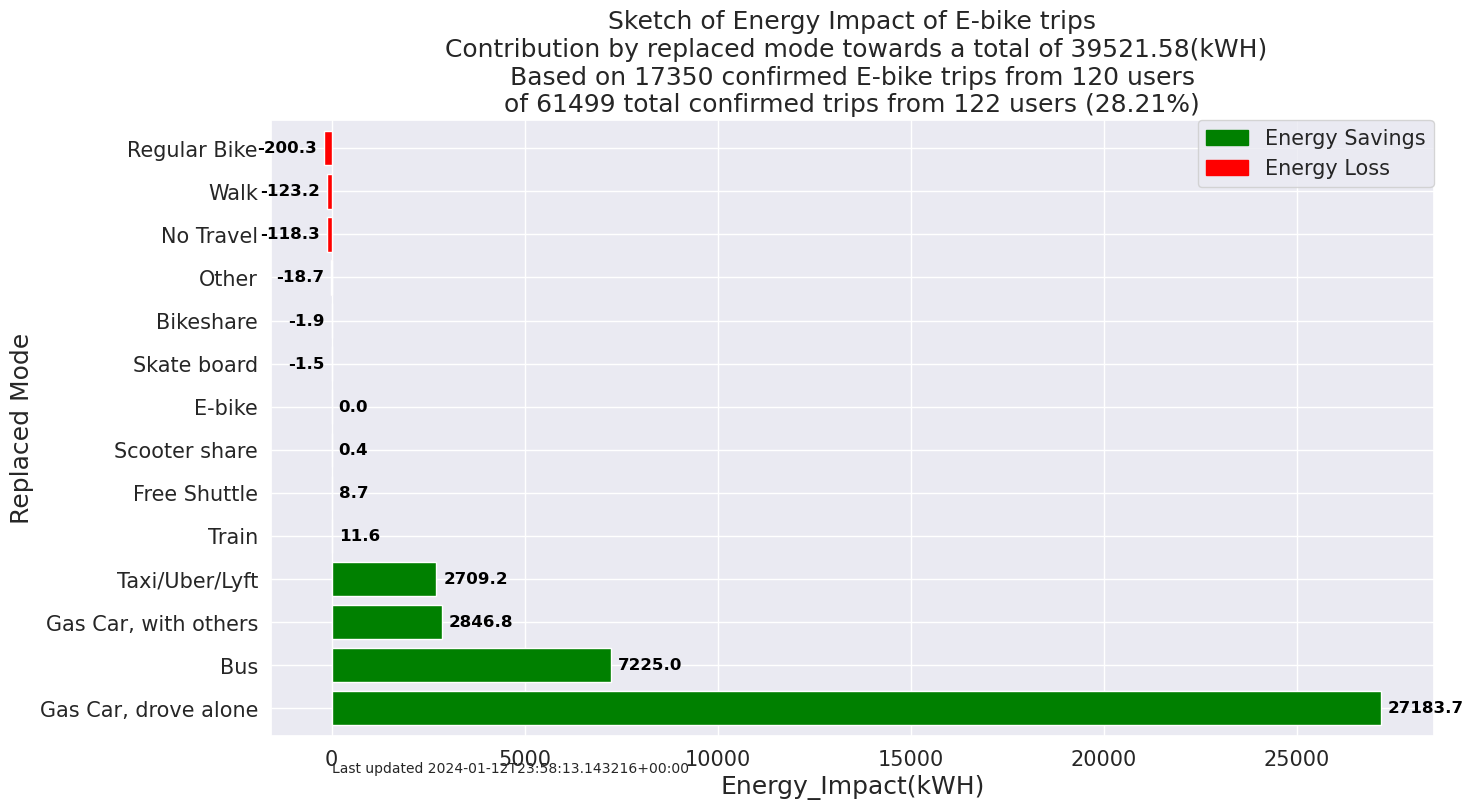

In [18]:
# ebei : ebike energy impact
plot_title_no_quality=f"Sketch of Energy Impact of {mode_of_interest} trips"
file_name =f'sketch_energy_impact_{mode_of_interest}%s'
    
ebei=data_eb.groupby('Replaced_mode').agg({'Energy_Impact(kWH)': ['sum', 'mean']},)
ebei.columns = ['Sketch of Total Energy_Impact(kWH)', 'Sketch of Average Energy_Impact(kWH)']
ebei= ebei.reset_index()
ebei = ebei.sort_values(by=['Sketch of Total Energy_Impact(kWH)'], ascending=False)
ebei['boolean'] = ebei['Sketch of Total Energy_Impact(kWH)'] > 0
net_energy_saved = round(sum(ebei['Sketch of Total Energy_Impact(kWH)']), 2)

x = ebei['Sketch of Total Energy_Impact(kWH)']
y = ebei['Replaced_mode']
color =ebei['boolean']

plot_title= plot_title_no_quality+f"\n Contribution by replaced mode towards a total of {net_energy_saved}(kWH)\n"+quality_text
energy_impact(x,y,color,plot_title,file_name)
alt_text = store_alt_text_bar(pd.DataFrame(x.values,y), file_name, plot_title)


### Sketch of CO2 emissions impact by trips of specified mode

Figure #27

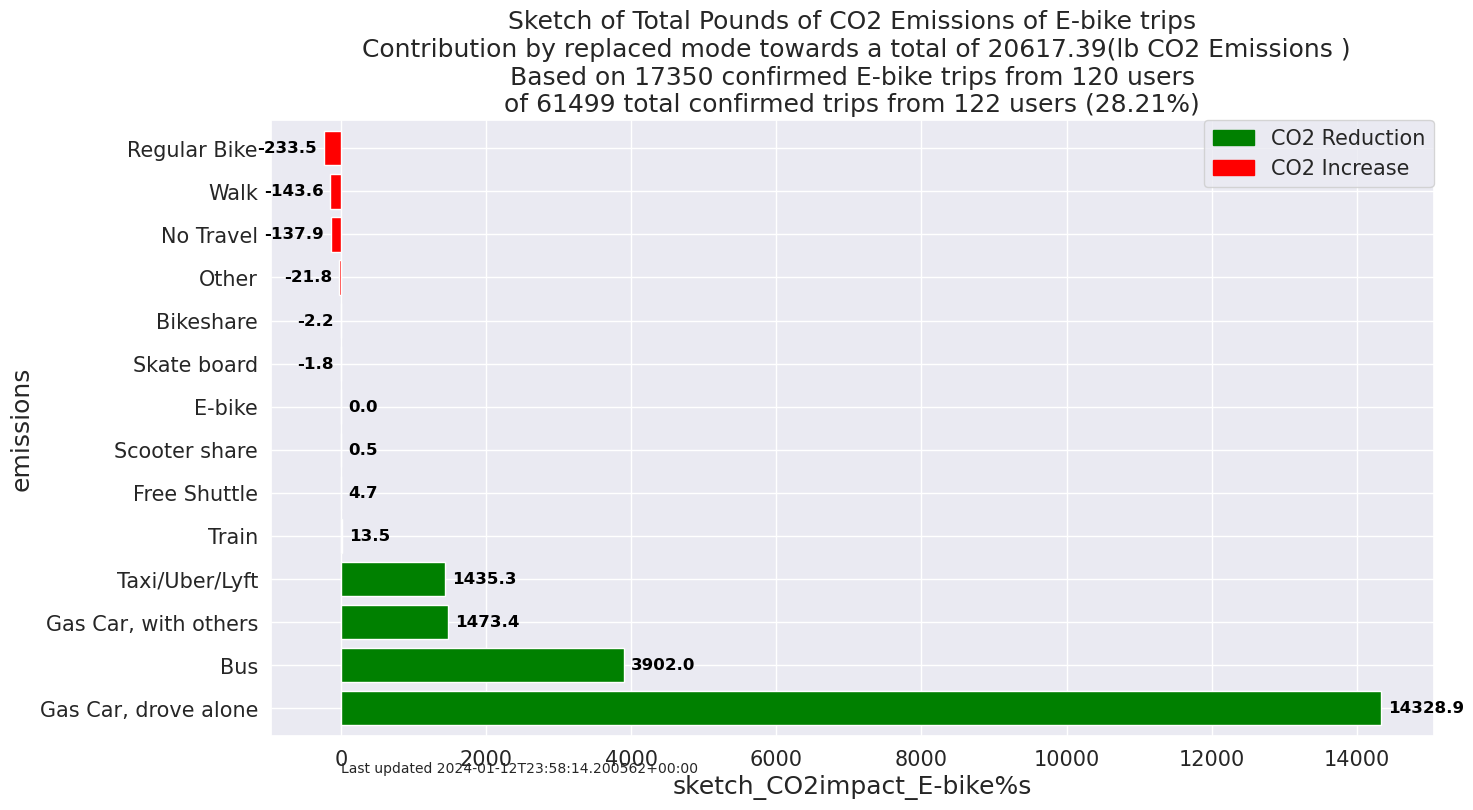

In [19]:
plot_title_no_quality=f"Sketch of Total Pounds of CO2 Emissions of {mode_of_interest} trips"
file_name =f'sketch_CO2impact_{mode_of_interest}%s'

try:
    ebco2=data_eb.groupby('Replaced_mode').agg({'CO2_Impact(lb)': ['sum', 'mean']},)
    ebco2.columns = ['total_lb_CO2_emissions', 'average_lb_CO2_emission']
    ebco2 = ebco2.reset_index()
    ebco2 = ebco2.sort_values(by=['total_lb_CO2_emissions'], ascending=False)
    ebco2['boolean'] = ebco2['total_lb_CO2_emissions'] > 0
    net_CO2_emissions = round(sum(ebco2['total_lb_CO2_emissions']), 2)

    x = ebco2['total_lb_CO2_emissions']
    y = ebco2['Replaced_mode']
    color = ebco2['boolean']

    plot_title= plot_title_no_quality+f"\n Contribution by replaced mode towards a total of {net_CO2_emissions}(lb CO2 Emissions )\n"+quality_text
    CO2_impact(x,y,color,plot_title,file_name,'emissions','please work')
    alt_text = store_alt_text_bar(pd.DataFrame(x.values,y), file_name, plot_title)
except:
    generate_missing_plot(plot_title_no_quality,debug_df,file_name)
    alt_text = store_alt_text_missing(debug_df, file_name, plot_title_no_quality)